## import libraries

In [1]:
!python3 -m pip install -e ../

Obtaining file:///fintech-optimization-pvc/projects/wankun01/playground/vit_pretrained_pytorch
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pytorch-pretrained-vit
    Found existing installation: pytorch-pretrained-vit 0.0.7
    Uninstalling pytorch-pretrained-vit-0.0.7:
      Successfully uninstalled pytorch-pretrained-vit-0.0.7
  Running setup.py develop for pytorch-pretrained-vit


In [2]:
!pip install torchsummary

In [3]:
import os, sys, shutil, json
from pytorch_pretrained_vit import ViT, ViT_CLS_FT
from torchsummary import summary
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd

## flow control

In [7]:
summarize_model = False
show_image_example = True
import torch
torch.manual_seed(42)
# regenerate_traffic_data = False

# set huggingface cache path on pvc
os.environ['TRANSFORMERS_CACHE'] = '/fintech-optimization-pvc/projects/wankun01/.huggingface_cache/'

## set up device and load pretrained model

In [8]:
device = torch.device("cuda:0") if torch.cuda.is_available() == True else torch.device("cpu")
print("Using device:", device)
model = ViT("B_16_imagenet1k", pretrained=True,
            representation_size=768,
            load_repr_layer=True,
           )
model.to(device)
if summarize_model:
    summary(model, input_size=(3,384,384)) # must be 384 for B_16

Using device: cuda:0
repr size None
None True
pre_logits_size 768
Loaded pretrained weights.


## create a small support dataset with predefined labels


In [10]:
# the classes in oki data could be: one-house area, centralized housing(masion etc), public(greenery) area
# first we try 3-way, 3-shot, meaning that we have three images for above classes.
nways = 4
nshots = 3
data_root = "../imgs"
public_set = ["zLW_BVRbb_Vi7qiI1bqvsw.jpg", "_dtiPwWJp7hGyjVzRvn-fQ.jpg", "0eiRArv0qPHxXulFxPCvcg.jpg"]
one_set = ["1fXgSae3CKmMSmnCWYVq7A.jpg", "1HDDK4WHB3ZSHFfI1eyxqg.jpg", "5pQydlqR9kYVUTYFLJCTRA.jpg"]
center_set = ["1UbKSUbcZ1WWtXqTBktP9w.jpg", "2imsDO2BncseuhMbCYe6Ag.jpg", "2ZzmVyV9HsqIDgfa5lS1eA.jpg"]
parking_set = ["B51xrhfEyaVA6vKQ8VjqZA.jpg", "B5EqDOgu4bpu37ilijjRYQ.jpg", "bFXPZ0zz-RbysCcWDfnpQQ.jpg"]

ground_truth = {0:"public greenary", 1:"one housing", 2:"centerized housing", 3:"parking lot"}
dataset_lst = [public_set, one_set, center_set, parking_set]

In [10]:
# define transforms
tsfm = transforms.Compose([transforms.Resize(model.image_size), 
                               transforms.ToTensor(), 
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                              ])

In [11]:
print(model.image_size)

(384, 384)


feature vector shape: torch.Size([1, 768])


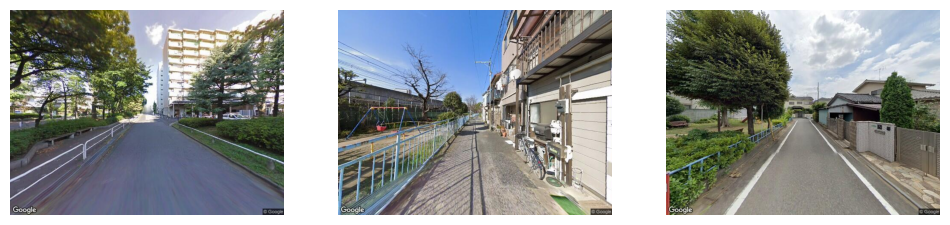

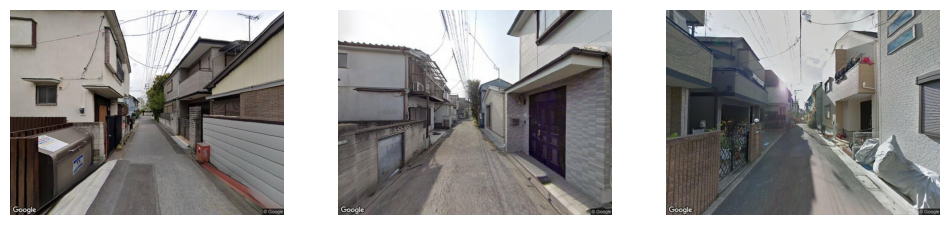

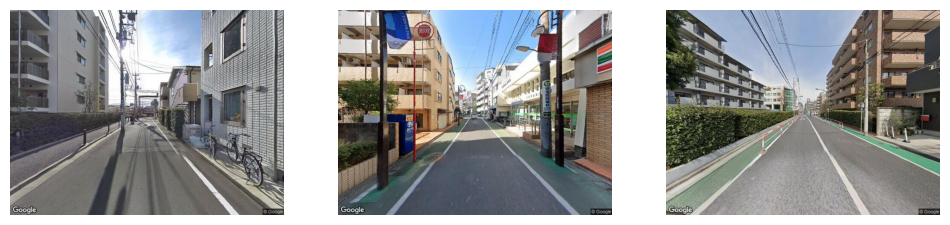

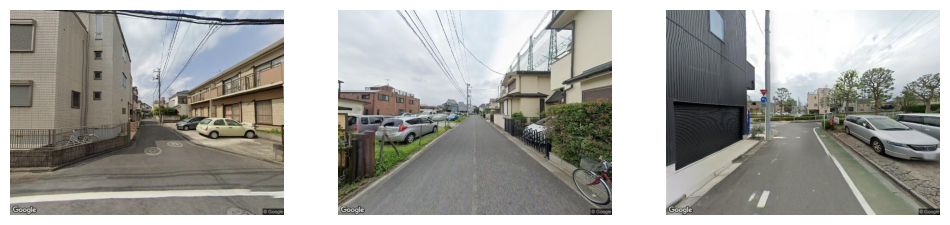

In [12]:
# now we use the pretrained model to extract the feature vectors of these imgs
model.eval() # set model to evaluate mode --> stop tracking gradients
representations = []
showsize = 128, 128
for dataset in dataset_lst:
    # for each type of the data, calculate the features mean first
    feature_vector = torch.tensor([0]*768, dtype=torch.float).to(device) # 768 dim
    fig = plt.figure(figsize=(12, 12))
    for i, shot in enumerate(dataset):
        img_path = os.path.join(data_root, shot)
        img = Image.open(img_path)
        a=fig.add_subplot(1,nshots,i+1)
        plt.imshow(img)
        plt.axis('off')
        # Preprocess image
        img = tsfm(img).unsqueeze(0)
        with torch.no_grad():
            outputs = model(img.to(device), logits=True).squeeze(0)
        # print(outputs.shape)
        feature_vector += outputs
    # print(feature_vector[0])
    feature_mean = 1/3 * feature_vector
    feature_mean_norm = F.normalize(feature_mean, dim=0)
    representations.append(feature_mean_norm.unsqueeze(0))

    # print(feature_mean_norm.shape)
    # print(feature_vector[0], feature_mean[0], feature_mean_norm[0])
print("feature vector shape:", representations[0].shape)

In [13]:
# the representation_set is [public, one, center]
# now use the same model to extract the feature vector for new data.
def extract_feature_vector(img_path, show=False):
    # feature_vector = torch.tensor([0]*768, dtype=torch.float).to(device) # 768 dim
    img = Image.open(img_path)
    if show:
        fig = plt.figure(figsize=(6,6))
        fig.add_subplot(1,1,1)
        plt.imshow(img)
    # Preprocess image
    img = tsfm(img).unsqueeze(0)
    with torch.no_grad():
        outputs = model(img.to(device), logits=True).squeeze(0)
    return F.normalize(outputs, dim=0)

In [14]:
# test with an example img
nclasses = len(representations)
print("N Classes:", nclasses)
pmatrix = torch.empty(nclasses, 768)
pmatrix = torch.cat(representations, dim=0)

N Classes: 4


## get ready for finetuning with support set

In [15]:
# define finetune data --> support set
X = []
y = []
for i, dataset in enumerate(dataset_lst):
    for fn in dataset:
        img_path = os.path.join(data_root, fn)
        X.append(extract_feature_vector(img_path).unsqueeze(0))
        y.append(i) 
        
X = torch.cat(X, dim=0).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)
print(X.shape, y.shape)

torch.Size([12, 768]) torch.Size([12])


## init cls head with proper values and configure training options

In [16]:
# the first option is to not let pretrained model weights to float.
# p(x) = softmax(w*x+b) where x is the feature vector from the feature extraction.
fc_w = pmatrix.clone().detach().requires_grad_(True) # this is recommended from pytorch doc
fc_b = torch.zeros((1,fc_w.shape[0]), dtype=torch.float, requires_grad=True)
print(fc_w.requires_grad, fc_b.requires_grad, fc_w.shape, fc_b.shape)

# torch.sum(torch.special.entr(torch.tensor([1,2,3]))) # just a test

# construct loss fn with cross-entropy and entropy regularization
def cross_entropy_regularized(output, target):
    # entropy regularization = - sum Pi * log(Pi) for Pi is the prob. for i-th class.
    
    entr =  torch.mean(torch.tensor([torch.sum(torch.special.entr(nn.Softmax(dim=0)(p))) for p in output], requires_grad=True))
    return nn.CrossEntropyLoss()(output, target) # + entr # todo: check if entr is affecting the BP
    
loss_fn = cross_entropy_regularized
# loss_fn = nn.CrossEntropyLoss()
# create a classification head with given init values
# from feature vector to 3 classes,not that we don't need softmax in torch here.
cls_head = nn.Linear(nclasses, 768)
# load the init values from the representation vectors
with torch.no_grad():
    cls_head.weight = nn.Parameter(fc_w.detach().clone())
    cls_head.bias = nn.Parameter(fc_b.detach().clone()) # --> use clone so only the values are passed into cls head
print(cls_head.bias)
print(cls_head.weight)
# construct optimizer
cls_head.to(device)
lr = 1e-1
optimizer = torch.optim.SGD(cls_head.parameters(), lr=lr)

True True torch.Size([4, 768]) torch.Size([1, 4])
Parameter containing:
tensor([[0., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([[ 0.0120, -0.0479,  0.0868,  ..., -0.0264, -0.0213, -0.0031],
        [ 0.0635, -0.0678,  0.0260,  ..., -0.0142, -0.0555,  0.0523],
        [ 0.0249, -0.0360,  0.0082,  ..., -0.0533, -0.0181,  0.0005],
        [ 0.0582, -0.1006,  0.0426,  ..., -0.0365, -0.0287, -0.0225]],
       device='cuda:0', requires_grad=True)


## training step (cls head only)

In [17]:
# training loop
# make sure data is on right device
print(X.device)
# set hyperparameters
n_epochs = 2000
for epoch in range(n_epochs):
    pred = cls_head(X)
    # print(pred.shape, y.shape)
    loss = loss_fn(pred, y)
    # reset autograd
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch:", epoch, "Loss:", loss.item())
    # print(pred.shape)

cuda:0
Epoch: 0 Loss: 1.2231040000915527
Epoch: 100 Loss: 0.9595488905906677
Epoch: 200 Loss: 0.7674257755279541
Epoch: 300 Loss: 0.6267598271369934
Epoch: 400 Loss: 0.522210955619812
Epoch: 500 Loss: 0.4429978132247925
Epoch: 600 Loss: 0.38177815079689026
Epoch: 700 Loss: 0.3335613012313843
Epoch: 800 Loss: 0.2949177324771881
Epoch: 900 Loss: 0.2634528577327728
Epoch: 1000 Loss: 0.23746512830257416
Epoch: 1100 Loss: 0.21572430431842804
Epoch: 1200 Loss: 0.19732584059238434
Epoch: 1300 Loss: 0.1815940886735916
Epoch: 1400 Loss: 0.16801653802394867
Epoch: 1500 Loss: 0.15619920194149017
Epoch: 1600 Loss: 0.14583542943000793
Epoch: 1700 Loss: 0.1366834044456482
Epoch: 1800 Loss: 0.12855054438114166
Epoch: 1900 Loss: 0.12128172069787979


In [18]:
# check the detach actually works, these two sets should be different
print(cls_head.bias)
print(cls_head.weight)
print(fc_b)
print(fc_w)

Parameter containing:
tensor([[ 0.6310, -0.1434, -0.5228,  0.0352]], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[-0.2560,  0.1639,  0.6353,  ...,  0.1617,  0.0666, -0.0297],
        [ 0.3202, -0.1350, -0.1269,  ...,  0.1703, -0.3864,  0.6679],
        [-0.1930,  0.3223, -0.4343,  ..., -0.3363,  0.1299, -0.0808],
        [ 0.2876, -0.6035,  0.0894,  ..., -0.1261,  0.0663, -0.5303]],
       device='cuda:0', requires_grad=True)
tensor([[0., 0., 0., 0.]], requires_grad=True)
tensor([[ 0.0120, -0.0479,  0.0868,  ..., -0.0264, -0.0213, -0.0031],
        [ 0.0635, -0.0678,  0.0260,  ..., -0.0142, -0.0555,  0.0523],
        [ 0.0249, -0.0360,  0.0082,  ..., -0.0533, -0.0181,  0.0005],
        [ 0.0582, -0.1006,  0.0426,  ..., -0.0365, -0.0287, -0.0225]],
       device='cuda:0', requires_grad=True)


## define functions to test prediction results with no-finetuning, head-finetuning

In [19]:
# no finetuning
def make_fewshots_pred_noft(img_path, pmatrix=pmatrix):
    test_vector = extract_feature_vector(img_path, show=True)
    # print(pmatrix.shape)
    prediction = nn.Softmax(dim=0)(torch.matmul(pmatrix, test_vector))
    print("-"*20)
    print("prediction with no-finetuning")
    for key, value in ground_truth.items():
        print(f"{value}:{prediction[key]*100:.04f}%")
    

In [20]:
# with cls_head finetuning
def make_fewshots_pred_ft(img_path):
    test_vector = extract_feature_vector(img_path, show=False)
    # print(pmatrix.shape)
    # prediction = nn.Softmax(dim=0)(torch.matmul(pmatrix, test_vector))
    prediction = nn.Softmax(dim=1)(cls_head(test_vector.unsqueeze(0))).squeeze()
    print("-"*20)
    print("prediction with head-finetuning")
    for key, value in ground_truth.items():
        print(f"{value}:{prediction[key]*100:.04f}%")

## finetuning with BP to the pretrained vit

In [5]:
# combine vit and cls head
# make a new model
# from pytorch_pretrained_vit import ViT_CLS_FT

In [9]:
# make a new vit
vit_ft = ViT("B_16_imagenet1k", pretrained=True,
            representation_size=768,
            load_repr_layer=True,
           )
vit_ft.to(device)
# make a new cls head with preset parameters
cls_head_ft = nn.Linear(nclasses, 768)
# load the init values from the representation vectors
with torch.no_grad():
    cls_head_ft.weight = nn.Parameter(fc_w.detach().clone())
    cls_head_ft.bias = nn.Parameter(fc_b.detach().clone())
print("init values for cls head:")
print(cls_head_ft.bias)
print(cls_head_ft.weight)
# make a combined model using above two
model_ft = ViT_CLS_FT(pretrained_vit_body=vit_ft, cls_head=cls_head_ft)
model_ft.to(device)
if False:
    summary(model_ft, input_size=(3,384,384))
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated(device=device)/1e9, "G")

repr size None
None True
pre_logits_size 768
Loaded pretrained weights.


NameError: name 'nclasses' is not defined

In [23]:
# define finetune data --> support set
X = []
y = []
for i, dataset in enumerate(dataset_lst):
    for fn in dataset:
        img_path = os.path.join(data_root, fn)
        img = Image.open(img_path)
        # Preprocess image
        img = tsfm(img).unsqueeze(0)
        X.append(img)
        y.append(i) 
        
X = torch.cat(X, dim=0).to(device)
y = torch.tensor(y, dtype=torch.long).to(device)
print(X.shape, y.shape) # b, c, h, w

batch_size = 2 # set to a small integer number.
class FTDataset(Dataset):
    def __init__(self, X, y):
        # X and y should be tensor of images and labels
        super().__init__()
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0] # size first
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
ft_dataset = FTDataset(X, y)
print(len(ft_dataset))
ft_dataloader = DataLoader(ft_dataset, batch_size=batch_size)

torch.Size([12, 3, 384, 384]) torch.Size([12])
12


In [24]:
n_epochs = 200
lr = 1e-4
optimizer = torch.optim.AdamW(model_ft.parameters(), lr=lr)

for epoch in range(n_epochs):
    total_loss = 0
    for X, y in ft_dataloader:
        # print(torch.cuda.memory_allocated(device=device)/1e9, "G")
        pred = model_ft(X)
        # print(pred.shape, y.shape)
        loss = loss_fn(pred, y)
        total_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_loss_avg = total_loss.item() / (len(ft_dataset) // batch_size)
    if epoch % 5 == 0:
        print("Epoch:", epoch, "Loss:", total_loss_avg)

    # print(pred.shape)

Epoch: 0 Loss: 1.3049789269765217
Epoch: 5 Loss: 1.0442878405253093
Epoch: 10 Loss: 0.9682339827219645
Epoch: 15 Loss: 0.9311683972676595
Epoch: 20 Loss: 0.9027208487192789
Epoch: 25 Loss: 0.8802940050760905
Epoch: 30 Loss: 0.859126885732015
Epoch: 35 Loss: 0.8374129931131998
Epoch: 40 Loss: 0.8181386788686117
Epoch: 45 Loss: 0.8017040888468424
Epoch: 50 Loss: 0.7860846519470215
Epoch: 55 Loss: 0.7709238529205322
Epoch: 60 Loss: 0.7571574846903483
Epoch: 65 Loss: 0.7431416511535645
Epoch: 70 Loss: 0.7312965393066406
Epoch: 75 Loss: 0.7198150952657064
Epoch: 80 Loss: 0.709224541982015
Epoch: 85 Loss: 0.6999850273132324
Epoch: 90 Loss: 0.691572109858195
Epoch: 95 Loss: 0.6827064355214437
Epoch: 100 Loss: 0.6752710342407227
Epoch: 105 Loss: 0.6689313252766927
Epoch: 110 Loss: 0.6625731388727824
Epoch: 115 Loss: 0.6566388607025146
Epoch: 120 Loss: 0.6509290536244711
Epoch: 125 Loss: 0.6464508374532064
Epoch: 130 Loss: 0.6417745351791382
Epoch: 135 Loss: 0.6371143658955892
Epoch: 140 Loss: 

## define function to test finetuned model (vit + mlp)

In [25]:
# with cls_head finetuning
def make_fewshots_pred_ft_all(img_path):
    # test_vector = extract_feature_vector(img_path, show=True)
    # print(pmatrix.shape)
    # prediction = nn.Softmax(dim=0)(torch.matmul(pmatrix, test_vector))
    img = Image.open(img_path)
    # Preprocess image
    img = tsfm(img).unsqueeze(0)
    prediction = nn.Softmax(dim=1)(model_ft(img.to(device))).squeeze(0)
    print("-"*20)
    print("prediction with \"vit + mlp\" finetuning")
    for key, value in ground_truth.items():
        print(f"{value}:{prediction[key]*100:.04f}%")
    print("-"*20)

## select any image to test results

In [26]:
test_img_path = os.path.join(data_root, "6cLJi56gTf67sG5r29DUTw.jpg")

--------------------
prediction with no-finetuning
public greenary:24.3692%
one housing:26.9851%
centerized housing:23.0100%
parking lot:25.6357%
--------------------
prediction with head-finetuning
public greenary:16.1499%
one housing:44.0784%
centerized housing:4.6590%
parking lot:35.1128%
--------------------
prediction with "vit + mlp" finetuning
public greenary:15.4292%
one housing:53.8306%
centerized housing:13.3731%
parking lot:17.3671%
--------------------


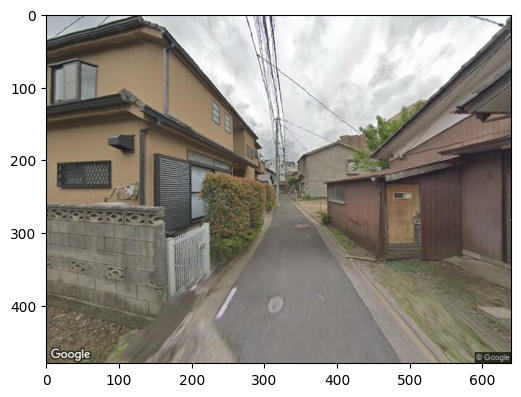

In [27]:
make_fewshots_pred_noft(test_img_path)
make_fewshots_pred_ft(test_img_path)
make_fewshots_pred_ft_all(test_img_path)

In [29]:
# save model parameters
model_ft_path = '../save_models/model_ft.pth'
cls_head_path = "../save_models/cls_head.pth"
torch.save(model_ft.state_dict(), model_ft_path)
torch.save(cls_head.state_dict(), cls_head_path)

# backup

## (optional) prepare traffic signs images into train and validation folders if needed

In [22]:
def prepare_traffic_train_val(root_path, targ_path, val_size=0.2, seed=42):
    files = glob(root_path)
    n_files = len(files)
    random.seed(seed)
    random.shuffle(files)
    os.makedirs(os.path.dirname(f"{targ_path}/train"), exist_ok=True)
    os.makedirs(os.path.dirname(f"{targ_path}/val"), exist_ok=True)
    # print(files)
    train_files, val_files = [], []
    for f in files[:int(n_files*(1-val_size))]:
        shutil.copy(f, f"{targ_path}/train")
        train_files.append(f)
    for f in files[int(n_files*(1-val_size)):]:
        shutil.copy(f, f"{targ_path}/val")
        val_files.append(f)
    return train_files, val_files

if regenerate_traffic_data:
    train_files, val_files = prepare_traffic_train_val("/mnt/data/projects/wankun01/playground/cv/rawdata/images/*", "/mnt/data/projects/wankun01/playground/cv/ViT-PyTorch/data")

In [ ]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files):
    fig = figure()
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image,cmap='Greys_r')
        axis('off')